# Knowledge Distillation
------------------------

Here we are going to perform a model compression technique known as **knowledge distillation** in which a `student` model "learns" from a more complex model known as the `teacher`. In particular we will:


1. Define a `Distiller` class with the custom logic for the distillation process.
2. Train the `teacher` model which is a CNN that implements regularization via dropout.
3. Train a `student` model (a smaller version of the teacher without regularization) by using knowledge distillation.
4. Train another `student` model from scratch without distillation called `student_scratch`.
5. Compare the three students.


This notebook is based on [this](https://keras.io/examples/vision/knowledge_distillation/) official Keras tutorial.

If you want a more theoretical approach to this topic be sure to check this paper [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531).

Let's get started!


## Imports

In [1]:
# For setting random seeds
import os
os.environ['PYTHONHASHSEED']=str(42)

# Libraries
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# More random seed setup
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Prepare the data

For this lab you will use the [cats vs dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) which is composed of many images of cats and dogs alongise their respective labels.

Begin by downloading the data:

In [2]:
# Define train/test splits
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# Download the dataset
(train_examples, validation_examples, test_examples), info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

# Print useful information
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print(f"There are {num_examples} images for {num_classes} classes.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteHBRPOI/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
There are 23262 images for 2 classes.


Preprocess the data for training by normalizing pixel values, reshaping them and creating batches of data:

In [3]:
# Some global variables
pixels = 224
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32

# Apply resizing and pixel normalization
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

# Create batches of data
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

## Code the custom `Distiller` model

In order to implement the distillation process we will create a custom Keras model which you will name `Distiller`. In order to do this we need to override some of the vanilla methods of a `keras.Model` to include the custom logic for the knowledge distillation. we need to override these methods:
- `compile`: This model needs some extra parameters to be compiled such as the teacher and student losses, the alpha and the temperature.
- `train_step`: Controls how the model is trained. This will be where the actual knowledge distillation logic will be found. This method is what is called when you do `model.fit`.
- `test_step`: Controls the evaluation of the model. This method is what is called when you do `model.evaluate`.

To learn more about customizing models check out the [official docs](https://keras.io/guides/customizing_what_happens_in_fit/).

In [4]:
class Distiller(keras.Model):

  # Needs both the student and teacher models to create an instance of this class
  def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student


  # Will be used when calling model.compile()
  def compile(self, optimizer, metrics, student_loss_fn,
              distillation_loss_fn, alpha, temperature):

      # Compile using the optimizer and metrics
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)

      # Add the other params to the instance
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature


  # Will be used when calling model.fit()
  def train_step(self, data):
      # Data is expected to be a tuple of (features, labels)
        x, y = data

       # Vanilla forward pass of the teacher
      # Note that the teacher is NOT trained
        teacher_predictions = self.teacher(x, training=False)

      # Use GradientTape to save gradients
        with tf.GradientTape() as tape:
            
          # Vanilla forward pass of the student
            student_predictions = self.student(x, training=True)

          # Compute vanilla student loss
            student_loss = self.student_loss_fn(y, student_predictions)

          # Compute distillation loss
          # Should be KL divergence between logits softened by a temperature factor
            distillation_loss = self.distillation_loss_fn(
              tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
              tf.nn.softmax(student_predictions / self.temperature, axis=1))

          # Compute loss by weighting the two previous losses using the alpha param
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

      # Use tape to calculate gradients for student
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

      # Update student weights
      # Note that this done ONLY for the student
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

      # Update the metrics
        self.compiled_metrics.update_state(y, student_predictions)

      # Return a performance dictionary
      # You will see this being outputted during training
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results


  # Will be used when calling model.evaluate()
  def test_step(self, data):
      # Data is expected to be a tuple of (features, labels)
        x, y = data

      # Use student to make predictions
      # Notice that the training param is set to False
        y_prediction = self.student(x, training=False)

      # Calculate student's vanilla loss
        student_loss = self.student_loss_fn(y, y_prediction)

      # Update the metrics
        self.compiled_metrics.update_state(y, y_prediction)

      # Return a performance dictionary
      # You will see this being outputted during inference
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


## Teacher and student models

For the models you will use a standard CNN architecture that implements regularization via some dropout layers (in the case of the teacher), but it could be any Keras model.

Define the `create_model` functions to create models with the desired architecture using Keras' [Sequential Model](https://keras.io/guides/sequential_model/).

Notice that `create_small_model` returns a simplified version of the model (in terms of number of layers and absence of regularization) that `create_big_model` returns:

In [5]:
# Teacher model
def create_big_model():
    
    tf.random.set_seed(42)
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.5),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(2)
      ])
    return model
#  ` 
    



# Student model
def create_small_model():
    tf.random.set_seed(42)
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(2)
      ])
    return model
    
    

There are two important things to notice:
- The last layer does not have an softmax activation because the raw logits are needed for the knowledge distillation.
- Regularization via dropout layers will be applied to the teacher but NOT to the student. This is because the student should be able to learn this regularization through the distillation process.

Remember that the student model can be thought of as a simplified (or compressed) version of the teacher model.



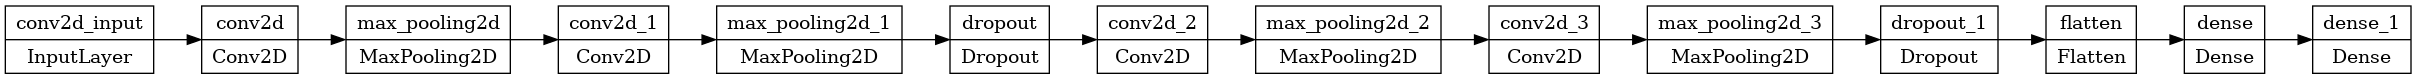

In [6]:
# Create the teacher
teacher = create_big_model()

# Plot architecture
keras.utils.plot_model(teacher, rankdir="LR")

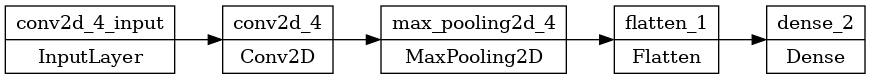

In [7]:
# Create the student
student = create_small_model()

# Plot architecture
keras.utils.plot_model(student, rankdir="LR")

Check the actual difference in number of trainable parameters (weights and biases) between both models:

In [8]:
# Calculates number of trainable params for a given model
def num_trainable_params(model):
  return np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])


student_params = num_trainable_params(student)
teacher_params = num_trainable_params(teacher)

print(f"Teacher model has: {teacher_params} trainable params.\n")
print(f"Student model has: {student_params} trainable params.\n")
print(f"Teacher model is roughly {teacher_params//student_params} times bigger than the student model.")

Teacher model has: 9568898 trainable params.

Student model has: 789442 trainable params.

Teacher model is roughly 12 times bigger than the student model.


### Train the teacher

In knowledge distillation it is assumed that the teacher has already been trained so the natural first step is to train the teacher. You will do so for a total of 8 epochs:

In [9]:
# Compile the teacher model
teacher.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Notice from_logits param is set to True
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Fit the model and save the training history 
teacher_history = teacher.fit(train_batches, epochs=8, validation_data=validation_batches)

Epoch 1/8


2023-06-30 17:02:40.845581: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 19/582 [..............................] - ETA: 27s - loss: 0.8302 - sparse_categorical_accuracy: 0.5132

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 50/582 [=>............................] - ETA: 27s - loss: 0.7453 - sparse_categorical_accuracy: 0.5050

 62/582 [==>...........................] - ETA: 27s - loss: 0.7352 - sparse_categorical_accuracy: 0.5030

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


133/582 [=====>........................] - ETA: 23s - loss: 0.7107 - sparse_categorical_accuracy: 0.5148

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 12s - loss: 0.6925 - sparse_categorical_accuracy: 0.5516

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


355/582 [=================>............] - ETA: 12s - loss: 0.6913 - sparse_categorical_accuracy: 0.5548

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/582 [=================>............] - ETA: 11s - loss: 0.6903 - sparse_categorical_accuracy: 0.5570

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 10s - loss: 0.6873 - sparse_categorical_accuracy: 0.5630

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


398/582 [===================>..........] - ETA: 9s - loss: 0.6865 - sparse_categorical_accuracy: 0.5646

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6685 - sparse_categorical_accuracy: 0.5908

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 50s 59ms/step - loss: 0.6685 - sparse_categorical_accuracy: 0.5908 - val_loss: 0.6253 - val_sparse_categorical_accuracy: 0.6359
Epoch 2/8
 19/582 [..............................] - ETA: 30s - loss: 0.6228 - sparse_categorical_accuracy: 0.6628

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 28s - loss: 0.6070 - sparse_categorical_accuracy: 0.6783

 62/582 [==>...........................] - ETA: 27s - loss: 0.5983 - sparse_categorical_accuracy: 0.6840

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


133/582 [=====>........................] - ETA: 24s - loss: 0.5940 - sparse_categorical_accuracy: 0.6819

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 12s - loss: 0.5658 - sparse_categorical_accuracy: 0.7072

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


354/582 [=================>............] - ETA: 12s - loss: 0.5648 - sparse_categorical_accuracy: 0.7079

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


364/582 [=================>............] - ETA: 11s - loss: 0.5642 - sparse_categorical_accuracy: 0.7073

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 10s - loss: 0.5626 - sparse_categorical_accuracy: 0.7091

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/582 [===================>..........] - ETA: 10s - loss: 0.5623 - sparse_categorical_accuracy: 0.7096

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5526 - sparse_categorical_accuracy: 0.7157

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 36s 54ms/step - loss: 0.5526 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.4876 - val_sparse_categorical_accuracy: 0.7666
Epoch 3/8
 18/582 [..............................] - ETA: 29s - loss: 0.5095 - sparse_categorical_accuracy: 0.7708

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 28s - loss: 0.5259 - sparse_categorical_accuracy: 0.7506

 62/582 [==>...........................] - ETA: 28s - loss: 0.5222 - sparse_categorical_accuracy: 0.7515

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


134/582 [=====>........................] - ETA: 23s - loss: 0.5013 - sparse_categorical_accuracy: 0.7652

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


341/582 [================>.............] - ETA: 13s - loss: 0.4934 - sparse_categorical_accuracy: 0.7613

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


354/582 [=================>............] - ETA: 12s - loss: 0.4919 - sparse_categorical_accuracy: 0.7624

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/582 [=================>............] - ETA: 11s - loss: 0.4905 - sparse_categorical_accuracy: 0.7634

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 10s - loss: 0.4885 - sparse_categorical_accuracy: 0.7645

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


398/582 [===================>..........] - ETA: 10s - loss: 0.4887 - sparse_categorical_accuracy: 0.7641

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4811 - sparse_categorical_accuracy: 0.7666

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 38s 58ms/step - loss: 0.4811 - sparse_categorical_accuracy: 0.7666 - val_loss: 0.4630 - val_sparse_categorical_accuracy: 0.7803
Epoch 4/8
 18/582 [..............................] - ETA: 30s - loss: 0.4579 - sparse_categorical_accuracy: 0.7917

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 29s - loss: 0.4556 - sparse_categorical_accuracy: 0.7862

 61/582 [==>...........................] - ETA: 28s - loss: 0.4489 - sparse_categorical_accuracy: 0.7889

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


134/582 [=====>........................] - ETA: 24s - loss: 0.4445 - sparse_categorical_accuracy: 0.7936

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 13s - loss: 0.4402 - sparse_categorical_accuracy: 0.7973

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


355/582 [=================>............] - ETA: 12s - loss: 0.4391 - sparse_categorical_accuracy: 0.7983

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/582 [=================>............] - ETA: 11s - loss: 0.4409 - sparse_categorical_accuracy: 0.7973

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


393/582 [===================>..........] - ETA: 10s - loss: 0.4414 - sparse_categorical_accuracy: 0.7971

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/582 [===================>..........] - ETA: 9s - loss: 0.4407 - sparse_categorical_accuracy: 0.7976 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4317 - sparse_categorical_accuracy: 0.8024

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 37s 54ms/step - loss: 0.4317 - sparse_categorical_accuracy: 0.8024 - val_loss: 0.4359 - val_sparse_categorical_accuracy: 0.7932
Epoch 5/8
 19/582 [..............................] - ETA: 30s - loss: 0.4234 - sparse_categorical_accuracy: 0.7812

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 28s - loss: 0.4110 - sparse_categorical_accuracy: 0.8033

 62/582 [==>...........................] - ETA: 27s - loss: 0.4072 - sparse_categorical_accuracy: 0.8065

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


134/582 [=====>........................] - ETA: 26s - loss: 0.3938 - sparse_categorical_accuracy: 0.8209

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


341/582 [================>.............] - ETA: 13s - loss: 0.3841 - sparse_categorical_accuracy: 0.8289

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


355/582 [=================>............] - ETA: 12s - loss: 0.3848 - sparse_categorical_accuracy: 0.8289

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/582 [=================>............] - ETA: 11s - loss: 0.3844 - sparse_categorical_accuracy: 0.8289

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 10s - loss: 0.3852 - sparse_categorical_accuracy: 0.8282

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/582 [===================>..........] - ETA: 10s - loss: 0.3866 - sparse_categorical_accuracy: 0.8273

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.3827 - sparse_categorical_accuracy: 0.8286

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 39s 58ms/step - loss: 0.3825 - sparse_categorical_accuracy: 0.8287 - val_loss: 0.4041 - val_sparse_categorical_accuracy: 0.8194
Epoch 6/8
 18/582 [..............................] - ETA: 30s - loss: 0.3518 - sparse_categorical_accuracy: 0.8490

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 28s - loss: 0.3393 - sparse_categorical_accuracy: 0.8517

 61/582 [==>...........................] - ETA: 27s - loss: 0.3382 - sparse_categorical_accuracy: 0.8514

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


134/582 [=====>........................] - ETA: 23s - loss: 0.3336 - sparse_categorical_accuracy: 0.8570

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 12s - loss: 0.3381 - sparse_categorical_accuracy: 0.8531

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


355/582 [=================>............] - ETA: 11s - loss: 0.3378 - sparse_categorical_accuracy: 0.8534

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/582 [=================>............] - ETA: 11s - loss: 0.3387 - sparse_categorical_accuracy: 0.8533

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 9s - loss: 0.3382 - sparse_categorical_accuracy: 0.8529 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/582 [===================>..........] - ETA: 9s - loss: 0.3384 - sparse_categorical_accuracy: 0.8528

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.3377 - sparse_categorical_accuracy: 0.8537

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 37s 54ms/step - loss: 0.3375 - sparse_categorical_accuracy: 0.8538 - val_loss: 0.3794 - val_sparse_categorical_accuracy: 0.8358
Epoch 7/8
 19/582 [..............................] - ETA: 31s - loss: 0.3085 - sparse_categorical_accuracy: 0.8717

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 28s - loss: 0.3048 - sparse_categorical_accuracy: 0.8695

 62/582 [==>...........................] - ETA: 28s - loss: 0.3026 - sparse_categorical_accuracy: 0.8720

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


133/582 [=====>........................] - ETA: 24s - loss: 0.2876 - sparse_categorical_accuracy: 0.8788

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 12s - loss: 0.2949 - sparse_categorical_accuracy: 0.8718

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


355/582 [=================>............] - ETA: 12s - loss: 0.2942 - sparse_categorical_accuracy: 0.8719

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/582 [=================>............] - ETA: 11s - loss: 0.2953 - sparse_categorical_accuracy: 0.8718

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


393/582 [===================>..........] - ETA: 10s - loss: 0.2976 - sparse_categorical_accuracy: 0.8714

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/582 [===================>..........] - ETA: 9s - loss: 0.2978 - sparse_categorical_accuracy: 0.8713

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.2952 - sparse_categorical_accuracy: 0.8735

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 38s 57ms/step - loss: 0.2951 - sparse_categorical_accuracy: 0.8735 - val_loss: 0.3656 - val_sparse_categorical_accuracy: 0.8457
Epoch 8/8
 18/582 [..............................] - ETA: 30s - loss: 0.2598 - sparse_categorical_accuracy: 0.8854

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 50/582 [=>............................] - ETA: 28s - loss: 0.2468 - sparse_categorical_accuracy: 0.8950

 61/582 [==>...........................] - ETA: 28s - loss: 0.2470 - sparse_categorical_accuracy: 0.8975

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


134/582 [=====>........................] - ETA: 23s - loss: 0.2505 - sparse_categorical_accuracy: 0.8976

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 13s - loss: 0.2448 - sparse_categorical_accuracy: 0.8967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


355/582 [=================>............] - ETA: 12s - loss: 0.2471 - sparse_categorical_accuracy: 0.8957

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


364/582 [=================>............] - ETA: 11s - loss: 0.2472 - sparse_categorical_accuracy: 0.8956

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 10s - loss: 0.2471 - sparse_categorical_accuracy: 0.8954

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


398/582 [===================>..........] - ETA: 10s - loss: 0.2471 - sparse_categorical_accuracy: 0.8953

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2474 - sparse_categorical_accuracy: 0.8965

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 37s 54ms/step - loss: 0.2474 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.3635 - val_sparse_categorical_accuracy: 0.8426


## Train a student from scratch for reference

In order to assess the effectiveness of the distillation process, train a model that is equivalent to the student but without doing knowledge distillation. Notice that the training is done for only 5 epochs:

In [10]:
# Create student_scratch model with the same characteristics as the original student
student_scratch = create_small_model()

# Compile it
student_scratch.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train and evaluate student trained from scratch (will take around 3 mins with GPU enabled)
student_scratch_history = student_scratch.fit(train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/5
 19/582 [..............................] - ETA: 23s - loss: 3.3568 - sparse_categorical_accuracy: 0.4786

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 23s - loss: 1.7288 - sparse_categorical_accuracy: 0.5153

 63/582 [==>...........................] - ETA: 22s - loss: 1.5284 - sparse_categorical_accuracy: 0.5248

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


133/582 [=====>........................] - ETA: 20s - loss: 1.0674 - sparse_categorical_accuracy: 0.5752

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


343/582 [================>.............] - ETA: 11s - loss: 0.7955 - sparse_categorical_accuracy: 0.6162

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


356/582 [=================>............] - ETA: 10s - loss: 0.7884 - sparse_categorical_accuracy: 0.6184

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/582 [=================>............] - ETA: 10s - loss: 0.7846 - sparse_categorical_accuracy: 0.6192

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


393/582 [===================>..........] - ETA: 8s - loss: 0.7698 - sparse_categorical_accuracy: 0.6236

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/582 [===================>..........] - ETA: 8s - loss: 0.7671 - sparse_categorical_accuracy: 0.6246

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.7101 - sparse_categorical_accuracy: 0.6459

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 32s 44ms/step - loss: 0.7101 - sparse_categorical_accuracy: 0.6459 - val_loss: 0.5972 - val_sparse_categorical_accuracy: 0.7034
Epoch 2/5
 20/582 [>.............................] - ETA: 25s - loss: 0.5179 - sparse_categorical_accuracy: 0.7563

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 52/582 [=>............................] - ETA: 24s - loss: 0.5132 - sparse_categorical_accuracy: 0.7482

 63/582 [==>...........................] - ETA: 23s - loss: 0.5140 - sparse_categorical_accuracy: 0.7505

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


134/582 [=====>........................] - ETA: 20s - loss: 0.5164 - sparse_categorical_accuracy: 0.7453

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 10s - loss: 0.5088 - sparse_categorical_accuracy: 0.7508

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


356/582 [=================>............] - ETA: 10s - loss: 0.5085 - sparse_categorical_accuracy: 0.7510

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


366/582 [=================>............] - ETA: 9s - loss: 0.5091 - sparse_categorical_accuracy: 0.7504

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


393/582 [===================>..........] - ETA: 8s - loss: 0.5062 - sparse_categorical_accuracy: 0.7523

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


398/582 [===================>..........] - ETA: 8s - loss: 0.5062 - sparse_categorical_accuracy: 0.7527

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5020 - sparse_categorical_accuracy: 0.7546

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 33s 47ms/step - loss: 0.5020 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.6209 - val_sparse_categorical_accuracy: 0.6840
Epoch 3/5
 20/582 [>.............................] - ETA: 25s - loss: 0.4026 - sparse_categorical_accuracy: 0.8375

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 52/582 [=>............................] - ETA: 23s - loss: 0.3932 - sparse_categorical_accuracy: 0.8305

 62/582 [==>...........................] - ETA: 23s - loss: 0.4011 - sparse_categorical_accuracy: 0.8271

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


135/582 [=====>........................] - ETA: 20s - loss: 0.3995 - sparse_categorical_accuracy: 0.8225

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 10s - loss: 0.3921 - sparse_categorical_accuracy: 0.8243

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


356/582 [=================>............] - ETA: 10s - loss: 0.3904 - sparse_categorical_accuracy: 0.8254

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


366/582 [=================>............] - ETA: 9s - loss: 0.3892 - sparse_categorical_accuracy: 0.8262

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


393/582 [===================>..........] - ETA: 8s - loss: 0.3871 - sparse_categorical_accuracy: 0.8278

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/582 [===================>..........] - ETA: 8s - loss: 0.3873 - sparse_categorical_accuracy: 0.8276

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3884 - sparse_categorical_accuracy: 0.8264

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 33s 47ms/step - loss: 0.3884 - sparse_categorical_accuracy: 0.8264 - val_loss: 0.6525 - val_sparse_categorical_accuracy: 0.7231
Epoch 4/5
 19/582 [..............................] - ETA: 31s - loss: 0.3004 - sparse_categorical_accuracy: 0.8799

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 26s - loss: 0.2895 - sparse_categorical_accuracy: 0.8879

 63/582 [==>...........................] - ETA: 25s - loss: 0.2957 - sparse_categorical_accuracy: 0.8810

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


134/582 [=====>........................] - ETA: 21s - loss: 0.2943 - sparse_categorical_accuracy: 0.8790

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


343/582 [================>.............] - ETA: 10s - loss: 0.2837 - sparse_categorical_accuracy: 0.8827

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


355/582 [=================>............] - ETA: 10s - loss: 0.2840 - sparse_categorical_accuracy: 0.8821

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/582 [=================>............] - ETA: 9s - loss: 0.2836 - sparse_categorical_accuracy: 0.8826

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 8s - loss: 0.2827 - sparse_categorical_accuracy: 0.8834

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


400/582 [===================>..........] - ETA: 8s - loss: 0.2828 - sparse_categorical_accuracy: 0.8832

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2811 - sparse_categorical_accuracy: 0.8849

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 32s 44ms/step - loss: 0.2811 - sparse_categorical_accuracy: 0.8849 - val_loss: 0.7169 - val_sparse_categorical_accuracy: 0.7163
Epoch 5/5
 20/582 [>.............................] - ETA: 27s - loss: 0.1854 - sparse_categorical_accuracy: 0.9406

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 24s - loss: 0.1849 - sparse_categorical_accuracy: 0.9375

 63/582 [==>...........................] - ETA: 23s - loss: 0.1903 - sparse_categorical_accuracy: 0.9330

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


134/582 [=====>........................] - ETA: 20s - loss: 0.1845 - sparse_categorical_accuracy: 0.9352

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


343/582 [================>.............] - ETA: 10s - loss: 0.1788 - sparse_categorical_accuracy: 0.9372

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


356/582 [=================>............] - ETA: 10s - loss: 0.1776 - sparse_categorical_accuracy: 0.9376

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


366/582 [=================>............] - ETA: 9s - loss: 0.1777 - sparse_categorical_accuracy: 0.9373

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


393/582 [===================>..........] - ETA: 8s - loss: 0.1784 - sparse_categorical_accuracy: 0.9364

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


398/582 [===================>..........] - ETA: 8s - loss: 0.1787 - sparse_categorical_accuracy: 0.9366

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1811 - sparse_categorical_accuracy: 0.9359

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 31s 45ms/step - loss: 0.1811 - sparse_categorical_accuracy: 0.9359 - val_loss: 0.8581 - val_sparse_categorical_accuracy: 0.7175


## Knowledge Distillation

To perform the knowledge distillation process we will use the custom model we previously coded. To do so, we will begin by creating an instance of the `Distiller` class and pass in the student and teacher models. Then compile it with the appropiate parameters and train it!

The two student models are trained for only 5 epochs unlike the teacher that was trained for 8. This is done to showcase that the knowledge distillation allows for quicker training times as the student learns from an already trained model.

In [11]:
# Create Distiller instance
distiller = Distiller(student=student, teacher=teacher)

# Compile Distiller model
distiller.compile(
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.05,
    temperature=5,
)

# Distill knowledge from teacher to student (will take around 3 mins with GPU enabled)
distiller_history = distiller.fit(train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/5
 20/582 [>.............................] - ETA: 22s - sparse_categorical_accuracy: 0.5141 - student_loss: 5.0716 - distillation_loss: 0.6805

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 23s - sparse_categorical_accuracy: 0.5294 - student_loss: 2.5039 - distillation_loss: 0.3259

 62/582 [==>...........................] - ETA: 23s - sparse_categorical_accuracy: 0.5312 - student_loss: 2.1812 - distillation_loss: 0.2862

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


133/582 [=====>........................] - ETA: 20s - sparse_categorical_accuracy: 0.5672 - student_loss: 1.3722 - distillation_loss: 0.1806

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


343/582 [================>.............] - ETA: 10s - sparse_categorical_accuracy: 0.6284 - student_loss: 0.9135 - distillation_loss: 0.1199

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


356/582 [=================>............] - ETA: 10s - sparse_categorical_accuracy: 0.6307 - student_loss: 0.9014 - distillation_loss: 0.1180

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


366/582 [=================>............] - ETA: 9s - sparse_categorical_accuracy: 0.6316 - student_loss: 0.8940 - distillation_loss: 0.1168

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


391/582 [===================>..........] - ETA: 8s - sparse_categorical_accuracy: 0.6363 - student_loss: 0.8758 - distillation_loss: 0.1140

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


398/582 [===================>..........] - ETA: 8s - sparse_categorical_accuracy: 0.6383 - student_loss: 0.8697 - distillation_loss: 0.1133

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.6614 - student_loss: 0.7832 - distillation_loss: 0.0988

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 33s 46ms/step - sparse_categorical_accuracy: 0.6614 - student_loss: 0.7832 - distillation_loss: 0.0987 - val_sparse_categorical_accuracy: 0.7197 - val_student_loss: 0.6755
Epoch 2/5
 20/582 [>.............................] - ETA: 26s - sparse_categorical_accuracy: 0.7516 - student_loss: 0.5152 - distillation_loss: 0.0628

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 52/582 [=>............................] - ETA: 24s - sparse_categorical_accuracy: 0.7284 - student_loss: 0.5394 - distillation_loss: 0.0605

 61/582 [==>...........................] - ETA: 24s - sparse_categorical_accuracy: 0.7264 - student_loss: 0.5484 - distillation_loss: 0.0597

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


133/582 [=====>........................] - ETA: 21s - sparse_categorical_accuracy: 0.7314 - student_loss: 0.5509 - distillation_loss: 0.0591

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 11s - sparse_categorical_accuracy: 0.7520 - student_loss: 0.5186 - distillation_loss: 0.0566

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


356/582 [=================>............] - ETA: 10s - sparse_categorical_accuracy: 0.7526 - student_loss: 0.5177 - distillation_loss: 0.0565

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


366/582 [=================>............] - ETA: 10s - sparse_categorical_accuracy: 0.7539 - student_loss: 0.5149 - distillation_loss: 0.0562

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


391/582 [===================>..........] - ETA: 9s - sparse_categorical_accuracy: 0.7558 - student_loss: 0.5126 - distillation_loss: 0.0556

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/582 [===================>..........] - ETA: 8s - sparse_categorical_accuracy: 0.7562 - student_loss: 0.5121 - distillation_loss: 0.0555

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.7605 - student_loss: 0.5076 - distillation_loss: 0.0545

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 32s 46ms/step - sparse_categorical_accuracy: 0.7606 - student_loss: 0.5078 - distillation_loss: 0.0545 - val_sparse_categorical_accuracy: 0.7377 - val_student_loss: 0.7768
Epoch 3/5
 20/582 [>.............................] - ETA: 26s - sparse_categorical_accuracy: 0.8188 - student_loss: 0.4352 - distillation_loss: 0.0411

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 52/582 [=>............................] - ETA: 25s - sparse_categorical_accuracy: 0.8023 - student_loss: 0.4366 - distillation_loss: 0.0414

 61/582 [==>...........................] - ETA: 24s - sparse_categorical_accuracy: 0.7971 - student_loss: 0.4419 - distillation_loss: 0.0410

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


134/582 [=====>........................] - ETA: 21s - sparse_categorical_accuracy: 0.8043 - student_loss: 0.4207 - distillation_loss: 0.0419

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


343/582 [================>.............] - ETA: 11s - sparse_categorical_accuracy: 0.8140 - student_loss: 0.4052 - distillation_loss: 0.0417

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


355/582 [=================>............] - ETA: 10s - sparse_categorical_accuracy: 0.8144 - student_loss: 0.4033 - distillation_loss: 0.0417

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


366/582 [=================>............] - ETA: 10s - sparse_categorical_accuracy: 0.8150 - student_loss: 0.4024 - distillation_loss: 0.0416

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


391/582 [===================>..........] - ETA: 9s - sparse_categorical_accuracy: 0.8152 - student_loss: 0.4008 - distillation_loss: 0.0413

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/582 [===================>..........] - ETA: 8s - sparse_categorical_accuracy: 0.8153 - student_loss: 0.4004 - distillation_loss: 0.0413

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8203 - student_loss: 0.3920 - distillation_loss: 0.0403

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 32s 46ms/step - sparse_categorical_accuracy: 0.8203 - student_loss: 0.3924 - distillation_loss: 0.0403 - val_sparse_categorical_accuracy: 0.7451 - val_student_loss: 0.8675
Epoch 4/5
 19/582 [..............................] - ETA: 26s - sparse_categorical_accuracy: 0.8717 - student_loss: 0.2965 - distillation_loss: 0.0284

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 52/582 [=>............................] - ETA: 25s - sparse_categorical_accuracy: 0.8594 - student_loss: 0.3117 - distillation_loss: 0.0324

 61/582 [==>...........................] - ETA: 24s - sparse_categorical_accuracy: 0.8540 - student_loss: 0.3243 - distillation_loss: 0.0325

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


133/582 [=====>........................] - ETA: 21s - sparse_categorical_accuracy: 0.8571 - student_loss: 0.3163 - distillation_loss: 0.0328

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 11s - sparse_categorical_accuracy: 0.8621 - student_loss: 0.3124 - distillation_loss: 0.0327

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


356/582 [=================>............] - ETA: 10s - sparse_categorical_accuracy: 0.8632 - student_loss: 0.3117 - distillation_loss: 0.0326

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


366/582 [=================>............] - ETA: 10s - sparse_categorical_accuracy: 0.8632 - student_loss: 0.3118 - distillation_loss: 0.0327

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


391/582 [===================>..........] - ETA: 9s - sparse_categorical_accuracy: 0.8640 - student_loss: 0.3106 - distillation_loss: 0.0325

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


399/582 [===================>..........] - ETA: 8s - sparse_categorical_accuracy: 0.8638 - student_loss: 0.3103 - distillation_loss: 0.0326

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8630 - student_loss: 0.3120 - distillation_loss: 0.0323

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 32s 46ms/step - sparse_categorical_accuracy: 0.8630 - student_loss: 0.3119 - distillation_loss: 0.0323 - val_sparse_categorical_accuracy: 0.7261 - val_student_loss: 0.9034
Epoch 5/5
 20/582 [>.............................] - ETA: 26s - sparse_categorical_accuracy: 0.9125 - student_loss: 0.2513 - distillation_loss: 0.0318

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/582 [=>............................] - ETA: 24s - sparse_categorical_accuracy: 0.8934 - student_loss: 0.2597 - distillation_loss: 0.0288

 62/582 [==>...........................] - ETA: 24s - sparse_categorical_accuracy: 0.8947 - student_loss: 0.2553 - distillation_loss: 0.0288

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


133/582 [=====>........................] - ETA: 21s - sparse_categorical_accuracy: 0.8863 - student_loss: 0.2654 - distillation_loss: 0.0284

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


343/582 [================>.............] - ETA: 11s - sparse_categorical_accuracy: 0.8894 - student_loss: 0.2601 - distillation_loss: 0.0280

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


356/582 [=================>............] - ETA: 10s - sparse_categorical_accuracy: 0.8894 - student_loss: 0.2596 - distillation_loss: 0.0279

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/582 [=================>............] - ETA: 10s - sparse_categorical_accuracy: 0.8896 - student_loss: 0.2603 - distillation_loss: 0.0278

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 9s - sparse_categorical_accuracy: 0.8897 - student_loss: 0.2591 - distillation_loss: 0.0277

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


400/582 [===================>..........] - ETA: 8s - sparse_categorical_accuracy: 0.8902 - student_loss: 0.2581 - distillation_loss: 0.0277

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8916 - student_loss: 0.2560 - distillation_loss: 0.0271

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 32s 46ms/step - sparse_categorical_accuracy: 0.8916 - student_loss: 0.2560 - distillation_loss: 0.0272 - val_sparse_categorical_accuracy: 0.7240 - val_student_loss: 1.0533


## Comparing the models

To compare the models you can check the `sparse_categorical_accuracy` of each one on the test set:

In [12]:
# Compute accuracies
student_scratch_acc = student_scratch.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")
distiller_acc = distiller.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")
teacher_acc = teacher.evaluate(test_batches, return_dict=True).get("sparse_categorical_accuracy")

# Print results
print(f"\n\nTeacher achieved a sparse_categorical_accuracy of {teacher_acc*100:.2f}%.\n")
print(f"Student with knowledge distillation achieved a sparse_categorical_accuracy of {distiller_acc*100:.2f}%.\n")
print(f"Student without knowledge distillation achieved a sparse_categorical_accuracy of {student_scratch_acc*100:.2f}%.\n")

 995/2326 [===========>..................] - ETA: 4s - loss: 0.7023 - sparse_categorical_accuracy: 0.7246

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 989/2326 [===========>..................] - ETA: 4s - sparse_categorical_accuracy: 0.7381 - student_loss: 0.6478

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 982/2326 [===========>..................] - ETA: 4s - loss: 0.3793 - sparse_categorical_accuracy: 0.8452

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


2326/2326 [==============================] - 9s 4ms/step - loss: 0.3555 - sparse_categorical_accuracy: 0.8517


Teacher achieved a sparse_categorical_accuracy of 85.17%.

Student with knowledge distillation achieved a sparse_categorical_accuracy of 72.79%.

Student without knowledge distillation achieved a sparse_categorical_accuracy of 71.24%.



The teacher model yields a higger accuracy than the two student models. This is expected since it was trained for more epochs while using a bigger architecture.

Notice that the student without distillation was outperfomed by the student with knowledge distillation.

Since we saved the training history of each model you can create a plot for a better comparison of the two student models.

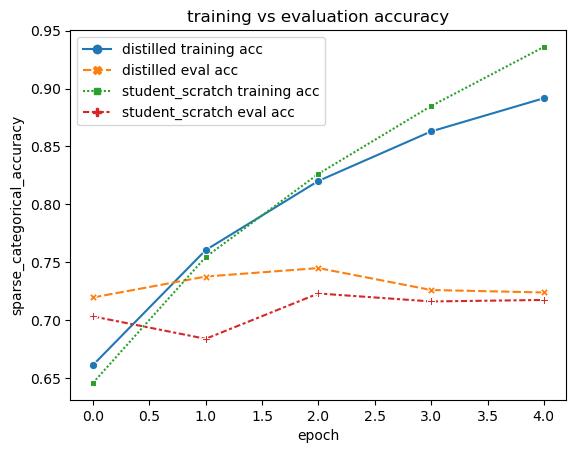

In [13]:
# Get relevant metrics from a history
def get_metrics(history):
  history = history.history
  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']
  return acc, val_acc


# Plot training and evaluation metrics given a dict of histories
def plot_train_eval(history_dict):

  metric_dict = {}

  for k, v in history_dict.items():
    acc, val_acc= get_metrics(v)
    metric_dict[f'{k} training acc'] = acc
    metric_dict[f'{k} eval acc'] = val_acc

  acc_plot = pd.DataFrame(metric_dict)

  acc_plot = sns.lineplot(data=acc_plot, markers=True)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()


# Plot for comparing the two student models
plot_train_eval({
    "distilled": distiller_history,
    "student_scratch": student_scratch_history,
})

This plot is very interesting because it shows that the distilled version outperformed the unmodified one in almost all of the epochs when using the evaluation set. Alongside this, the student without distillation yields a bigger training accuracy, which is a sign that it is overfitting more than the distilled model. **This hints that the distilled model was able to learn from the regularization that the teacher implemented!** Pretty cool, right?